In [2]:
import pandas as pd
import numpy as np
import utils as utils
import statsmodels.api as sm
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


# Data Cleaning

In [3]:
# Import brka data

brk_data = pd.read_csv("data/BRK-A.csv", parse_dates=True, index_col=0)
brk_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-01,8675.0,8725.0,6950.0,7455.0,7455.0,1047000
1990-02-01,7455.0,7950.0,7075.0,7225.0,7225.0,751000
1990-03-01,7225.0,7475.0,6675.0,6725.0,6725.0,630000
1990-04-01,6700.0,7025.0,6575.0,6700.0,6700.0,430000
1990-05-01,6700.0,7675.0,6700.0,7150.0,7150.0,427000


In [4]:
# Calculate monthly returns for brka portfolio

brk_data["rets"] = (brk_data["Close"] - brk_data["Open"]) / brk_data["Open"]
brk_data = brk_data.to_period('M')
brk_data.tail()

,Open,High,Low,Close,Adj Close,Volume,rets
Date,,,,,,,
2020-05,278121.0,280899.0,250926.00,278640.0,278640.0,8500,0.001866
2020-06,278167.0,304990.0,262700.00,267300.0,267300.0,13700,-0.039066
2020-07,267600.0,294870.0,266357.00,293631.0,293631.0,7700,0.097276
2020-08,295000.0,323500.0,294510.00,316251.0,316251.0,45000,0.072037
2020-08,317300.0,318000.0,315402.25,316251.0,316251.0,222,-0.003306


In [5]:
# Import fama-french data and convert to %

fff_data = pd.read_csv("data/fama_french.csv", header=0, index_col=0, na_values=-99.99)/100
fff_data.index = pd.to_datetime(fff_data.index, format="%Y%m").to_period('M')
fff_data.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
2020-02,-0.0813,-0.0007,-0.0401,-0.0164,-0.0253,0.0012
2020-03,-0.1339,-0.0845,-0.1412,-0.0133,0.0122,0.0012
2020-04,0.1365,0.0282,-0.0127,0.0259,-0.0109,0.0000
2020-05,0.0558,0.0192,-0.0495,0.0072,-0.0332,0.0001
2020-06,0.0245,0.0189,-0.0203,0.0013,0.0037,0.0001


# CAPM Benchmark

Text(0.5, 1.0, 'CAPM')

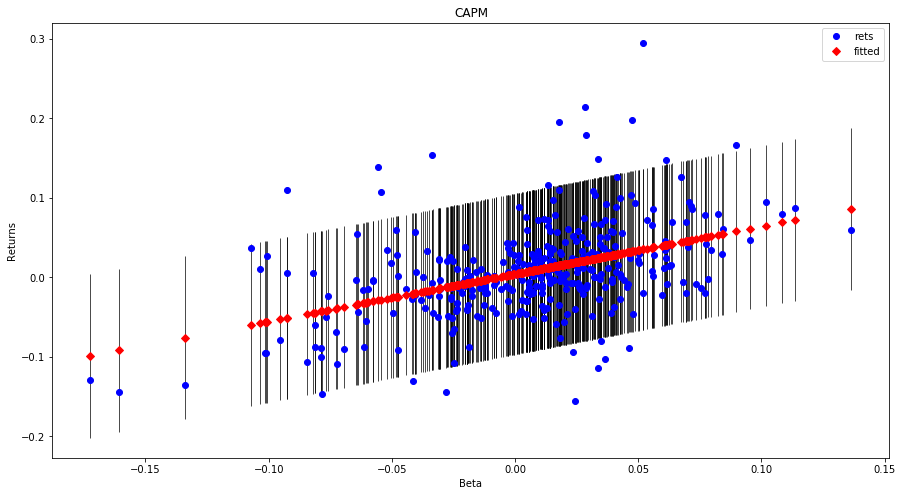

In [6]:
brka_excess = brk_data.loc["1990":"2020-06", ['rets']] - fff_data.loc["1990":"2020-06", ['RF']].values
mkt_excess = fff_data.loc["1990":"2020-06", ['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
capm_lm = sm.OLS(brka_excess, exp_var).fit()

fig, ax = plt.subplots(figsize=(15,8))
fig = sm.graphics.plot_fit(capm_lm, 0 , ax=ax)
ax.set_ylabel("Returns")
ax.set_xlabel("Beta")
ax.set_title("CAPM")

In [7]:
capm_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rets   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     93.82
Date:                Tue, 18 Aug 2020   Prob (F-statistic):           6.83e-20
Time:                        15:16:00   Log-Likelihood:                 568.67
No. Observations:                 366   AIC:                            -1133.
Df Residuals:                     364   BIC:                            -1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5980      0.062      9.686      0.000       0.477       0.719
Constant       0.0043      0.003      1.582      0.114      -0.001       0.010
==============================================================================
Omnibus:                       72.434   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.268
Skew:                           0.880   Prob(JB):                     7.35e-50
Kurtosis:                       6.427   Cond. No.                         23.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# CAPM Interpretation
Each dollar in the BRKA portfolio is equivalent to 59 cents in Treasury Bills and 41 cents in the market

𝛼 value of 0.4% relative to market

# Fama-French Benchmark

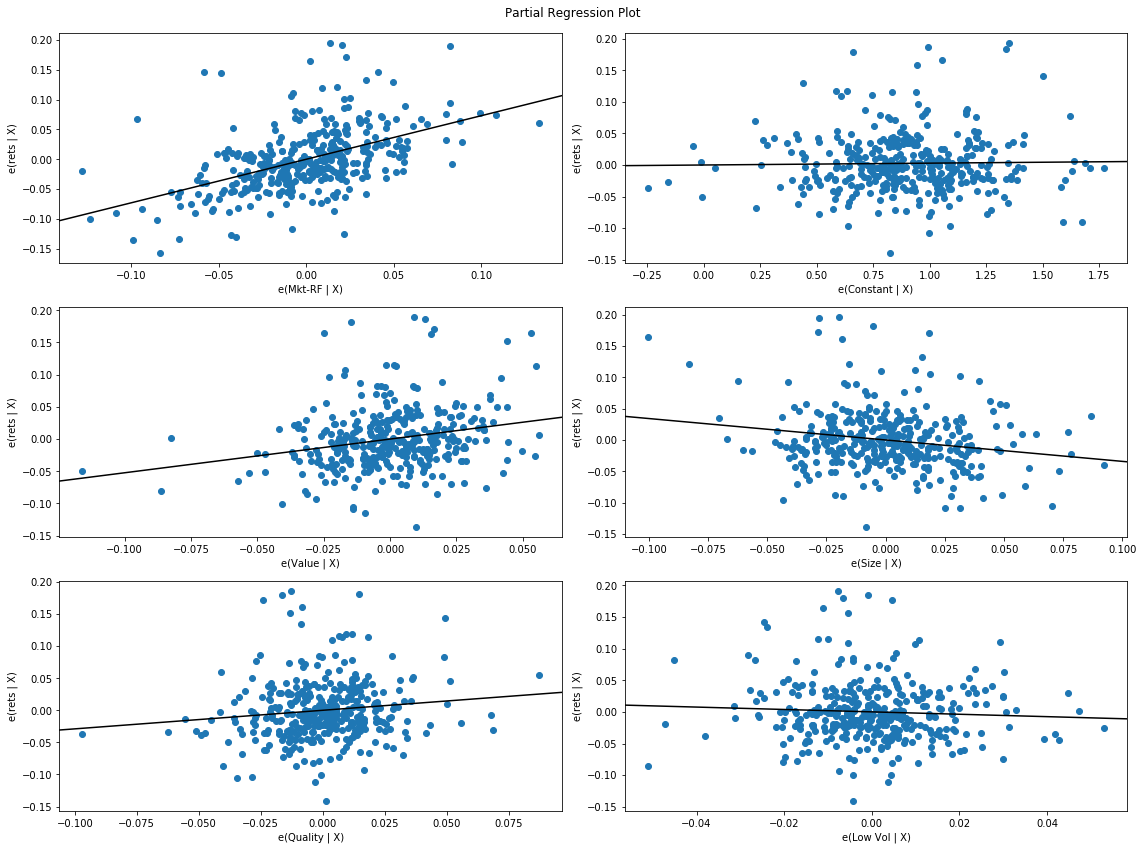

In [8]:
exp_var["Value"] = fff_data.loc["1990":"2020-06",['HML']]
exp_var["Size"] = fff_data.loc["1990":"2020-06",['SMB']]
exp_var["Quality"] = fff_data.loc["1990":"2020-06",['RMW']]
exp_var["Low Vol"] = fff_data.loc["1990":"2020-06",['CMA']]
fff_lm = sm.OLS(brka_excess, exp_var).fit()

fig = plt.figure(figsize=(16,12))
sm.graphics.plot_partregress_grid(fff_lm, fig=fig)
plt.show()

In [9]:
fff_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rets   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     38.69
Date:                Tue, 18 Aug 2020   Prob (F-statistic):           9.30e-32
Time:                        15:16:01   Log-Likelihood:                 605.40
No. Observations:                 366   AIC:                            -1199.
Df Residuals:                     360   BIC:                            -1175.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.7285      0.067     10.884      0.000       0.597       0.860
Constant       0.0029      0.003      1.130      0.259      -0.002       0.008
Value          0.5231      0.112      4.650      0.000       0.302       0.744
Size          -0.3419      0.091     -3.774      0.000      -0.520      -0.164
Quality        0.2894      0.121      2.391      0.017       0.051       0.527
Low Vol       -0.1890      0.170     -1.113      0.266      -0.523       0.145
==============================================================================
Omnibus:                       75.699   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.759
Skew:                           1.022   Prob(JB):                     9.25e-40
Kurtosis:                       5.759   Cond. No.                         79.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fama-French Interpretation
 - BRKA primarily invests in value stocks
 - BRKA for everydollar:
     - 73 cents in market, 27 cents in T-bills
     - Long 52 cents on value stocks, short 52 cents in growth stocks
     - Short 34 cents in Smallcaps, Long 34 cents in LargeCaps
     - Long 29 cents on profitable companies, short 29 cents on non-profitable companies
     - Short 19 cents on low-vol stocks, long 19 cents on high-vol stocks
 - If we follow the above, we will still underperform BRKA by 0.29%